In [2]:

from ultralytics import YOLO
import pandas as pd
import re
import numpy as np
import cv2
import math

c:\Users\alira\anaconda3\envs\CricVision\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [49]:

def open_video(video_path):
    vid=list()
    cap=cv2.VideoCapture(video_path)
    frameCount = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frameWidth = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frameHeight = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    buf = np.empty((frameCount, frameHeight, frameWidth, 3), np.dtype('uint8'))
    fc=0
    while True:
        ret, frame = cap.read()
        if not ret: break # break if no next frame
        
        # buf[fc]=frame # append frame
        # fc+=1
        vid.append(frame)
    # release and destroy windows
    cap.release()
    cv2.destroyAllWindows()
    return vid


    

In [4]:
def save_video(vid,name):
    fourcc = cv2.VideoWriter_fourcc(*'MP4V')
    frame_width=len(vid[0][0])
    frame_height=len(vid[0])
    out = cv2.VideoWriter(name, fourcc, 25.0, (frame_width, frame_height))
    for frame in vid:
        out.write(frame)
    out.release

In [31]:
def detect(vid):
    model=YOLO('v2.pt')
    results=model(vid)
    df=pd.DataFrame(columns=["Frame","Class","Confidence","Xmin","Ymin","Xmax","Ymax","Xc","Yc","W","H","A"])
    for result in results:
        for box in result.boxes:
            xyxy=box.xyxy.numpy()[0]
            xywh=box.xywh.numpy()[0]
            frame_number=int(re.search('(?<=image)\d+',result.path).group())
            cls="Bat" if box.cls==2 else "Ball" if box.cls==0 else "Batsman"
            df.loc[len(df)]=[frame_number,cls,int(float(box.conf)*100),xyxy[0],xyxy[1],xyxy[2],xyxy[3],xywh[0],xywh[1],xywh[2],xywh[3],xywh[2]*xywh[3]]
    return df

In [6]:
def suppress_duplicates(detections):
    # assuming your data frame is named `detections`
    # and has the columns `Frame`, `Class`, and `Confidence`

    # group by frame number and class name
    groups = detections.groupby(['Frame', 'Class'])

    # filter rows to keep only the detection with the highest confidence score for each group
    filtered_detections = groups.apply(lambda x: x.loc[x['Confidence'].idxmax()])

    # reset index of the filtered data frame
    filtered_detections = filtered_detections.reset_index(drop=True)
    
    return filtered_detections

In [46]:
def calculate_distances(detections):
    bat_ball = detections.loc[detections['Class'].isin(['Bat', 'Ball'])]

    # group rows by Frame
    groups = bat_ball.groupby('Frame')

    # compute distance between Bat and Ball coordinates for each group
    distances = []
    for name, group in groups:
        bat_coords = group.loc[group['Class'] == 'Bat', ['Xc', 'Yc']].values
        ball_coords = group.loc[group['Class'] == 'Ball', ['Xc', 'Yc']].values
        if len(bat_coords) > 0 and len(ball_coords) > 0:
            # distance = np.linalg.norm(bat_coords - ball_coords)
            distance=math.dist(bat_coords[0],ball_coords[0])
            distances.append((name, distance))

    # create a new data frame with the distances
    distances_df = pd.DataFrame(distances, columns=['Frame', 'Distance'])
    return distances_df

def detect_impact_frame(detections):
    distances_df=calculate_distances(detections)
    f_impact=distances_df.loc[distances_df['Distance'].idxmin()]["Frame"]
    return int(f_impact)


In [47]:
def detect_bounce_frame(detections,f_impact):
    ball_detections=detections.loc[(detections["Class"]=="Ball") & (detections["Frame"]<f_impact)]#class is ball and frame is before impact frame
    f_bounce=ball_detections.loc[ball_detections['Yc'].idxmax()]["Frame"]#get point where y-axis is max
    return int(f_bounce)

In [9]:
def visualize_bounding_boxes(detections, vid, classes):
    # create a list to store the output frames
    output_frames = []
    
    # loop over each frame in the video
    for frame_number, frame in enumerate(vid):
        # create a copy of the frame
        output_frame = np.copy(frame)
        
        # select rows for the specified classes
        selected_rows = detections[detections['Class'].isin(classes) & (detections['Frame'] == frame_number)]
        
        # loop over the selected rows and draw bounding boxes on the output frame
        for index, row in selected_rows.iterrows():
            class_name = row['Class']
            xmin = int(row['Xmin'])
            ymin = int(row['Ymin'])
            xmax = int(row['Xmax'])
            ymax = int(row['Ymax'])
            color = (0, 255, 0)  # set the color for the bounding box
            
            # draw the bounding box on the output frame
            cv2.rectangle(output_frame, (xmin, ymin), (xmax, ymax), color, 2)
            cv2.putText(output_frame, class_name, (xmin, ymin - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
        
        # add the output frame to the list of output frames
        output_frames.append(output_frame)
    
    # return the list of output frames
    return output_frames

In [10]:
def bowlerSideEstimation(detections):
    bat_ball = detections.loc[detections['Class'].isin(['Ball', 'Batsman'])]

    # group rows by Frame
    groups = bat_ball.groupby('Frame')

    # compute distance between Bat and Ball coordinates for each group
    distances = []
    for name, group in groups:
        batsman_coords = group.loc[group['Class'] == 'Batsman', ['Xc', 'Yc']].values
        ball_coords = group.loc[group['Class'] == 'Ball', ['Xc', 'Yc']].values
        if len(batsman_coords) > 0 and len(ball_coords) > 0:
            # distance = np.linalg.norm(bat_coords - ball_coords)
            x_vect=batsman_coords[0][0]-ball_coords[0][0]
            if x_vect>0:
                return "LEFT"
            else:
                return "RIGHT"

In [11]:
vid=open_video('7.2.23/1.mp4')

1920
1080


In [12]:
detections=detect(vid)

Ultralytics YOLOv8.0.49  Python-3.9.15 torch-1.13.1+cpu CPU
Model summary (fused): 168 layers, 11126745 parameters, 0 gradients, 28.4 GFLOPs

0: 736x1280 1 BM, 2 BTs, 1: 736x1280 1 BM, 1 BT, 2: 736x1280 1 BM, 1 BT, 3: 736x1280 1 BM, 1 BT, 4: 736x1280 1 BM, 1 BT, 5: 736x1280 1 BM, 1 BT, 6: 736x1280 1 BM, 1 BT, 7: 736x1280 1 BM, 1 BT, 8: 736x1280 1 BM, 1 BT, 9: 736x1280 1 BM, 1 BT, 10: 736x1280 1 BM, 1 BT, 11: 736x1280 1 BM, 1 BT, 12: 736x1280 1 BM, 2 BTs, 13: 736x1280 1 BM, 1 BT, 14: 736x1280 1 BM, 2 BTs, 15: 736x1280 1 BM, 2 BTs, 16: 736x1280 1 BM, 2 BTs, 17: 736x1280 1 BM, 2 BTs, 18: 736x1280 1 B, 1 BM, 1 BT, 19: 736x1280 1 B, 1 BM, 2 BTs, 20: 736x1280 1 B, 1 BM, 1 BT, 21: 736x1280 1 B, 1 BM, 1 BT, 22: 736x1280 1 B, 1 BM, 1 BT, 23: 736x1280 1 B, 1 BM, 1 BT, 24: 736x1280 1 B, 1 BM, 1 BT, 25: 736x1280 1 B, 1 BM, 1 BT, 26: 736x1280 1 B, 1 BM, 1 BT, 27: 736x1280 1 BM, 1 BT, 28: 736x1280 1 B, 1 BM, 2 BTs, 29: 736x1280 1 B, 1 BM, 1 BT, 30: 736x1280 1 B, 1 BM, 2 BTs, 31: 736x1280 1 B, 1 BM, 

In [13]:
detections

,Frame,Class,Confidence,Xmin,Ymin,...,Ymax,Xc,Yc,W,H
0,0,Batsman,92,905.0,217.0,...,408.0,947.5,312.5,85.0,191.0
1,0,Bat,69,905.0,268.0,...,310.0,928.5,289.0,47.0,42.0
2,0,Bat,47,903.0,268.0,...,300.0,925.5,284.0,45.0,32.0
3,1,Batsman,93,902.0,217.0,...,410.0,946.0,313.5,88.0,193.0
4,1,Bat,65,901.0,266.0,...,308.0,926.0,287.0,50.0,42.0
...,...,...,...,...,...,...,...,...,...,...,...
88,33,Batsman,94,802.0,135.0,...,764.0,912.5,449.5,221.0,629.0
89,33,Ball,78,1718.0,395.0,...,420.0,1732.0,407.5,28.0,25.0
90,33,Bat,74,964.0,135.0,...,373.0,997.0,254.0,66.0,238.0
91,34,Batsman,93,804.0,125.0,...,780.0,909.0,452.5,210.0,655.0


In [14]:
detections=suppress_duplicates(detections)

In [15]:
f_impact=detect_impact_frame(detections)

In [16]:
ball=detections.loc[detections["Class"]=="Ball"]

In [17]:
print(bowlerSideEstimation(detections))

LEFT


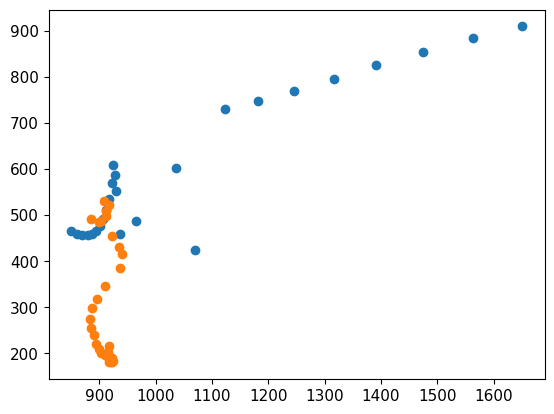

In [35]:
%matplotlib inline
ball=detections.loc[detections["Class"]=="Ball"]
bat=detections.loc[detections["Class"]=="Bat"]
import matplotlib.pyplot as plt
plt.scatter(ball["Xc"],ball["Yc"])
plt.scatter(bat["Xc"],bat["Yc"])
plt.show()


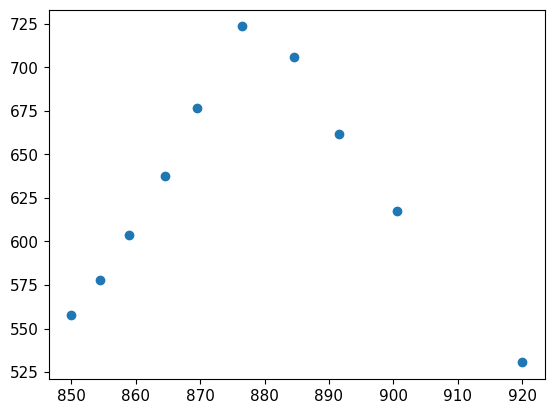

In [19]:
%matplotlib inline
ball=detections.loc[(detections["Class"]=="Ball") & (detections["Frame"]<f_impact)]#class is ball and frame is before impact frame
import matplotlib.pyplot as plt
plt.scatter(ball["Xc"],ball["Yc"])
plt.show()


In [20]:
f_bounce=detect_bounce_frame(detections,f_impact)

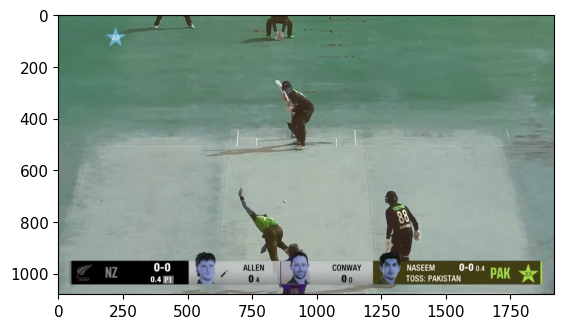

In [21]:
plt.imshow(vid[f_bounce])

In [22]:
annotated_video=visualize_bounding_boxes(detections,vid,["Bat","Ball"])
save_video(annotated_video,"output.mp4")

In [ ]:
for i in range(1,41):
    vid=open_video(f'7.2.23/{i}.mp4')
    detections=detect(vid)
    detections=suppress_duplicates(detections)
    detections.to_csv(f'detections/7.2.23/{i}.csv')

In [39]:
import matplotlib.pyplot as plt
for i in range(1,41):
    detections=pd.read_csv(f'detections/7.2.23/{i}.csv')
    ball=detections.loc[detections["Class"]=="Ball"]
    bat=detections.loc[detections["Class"]=="Bat"]
    plt.plot(ball["Xc"],ball["Yc"])
    plt.plot(bat["Xc"],bat["Yc"])
    plt.savefig(f'plots/7.2.23/line/{i}.png',format='png')
    plt.close()
    print(i)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40


In [48]:
for i in range(1,41):
    detections=pd.read_csv(f'detections/7.2.23/{i}.csv')
    vid=open_video(f'7.2.23/{i}.mp4')
    f_impact=detect_impact_frame(detections)
    f_bounce=detect_bounce_frame(detections,f_impact)
    # print(f'{f_impact},{f_bounce}')
    plt.imsave(f'validate/impact/7.2.23/{i}.jpg',vid[f_impact])
    plt.imsave(f'validate/bounce/7.2.23/{i}.jpg',vid[f_bounce])
    plt.close()
    print(i)

1920
1080
1
1920
1080
2
1920
1080
3
1920
1080
4
1920
1080
5
1920
1080
6
1920
1080
7
1920
1080
8
1920
1080
9
1920
1080
10
1920
1080
11
1920
1080
12
1920
1080
13
1920
1080
14
1920
1080
15
1920
1080
16
1920
1080
17
1920
1080
18
1920
1080
19
1920
1080
20
1920
1080
21
1920
1080
22
1920
1080
23
1920
1080
24
1920
1080
25
1920
1080
26
1920
1080
27
1920
1080
28
1920
1080
29
1920
1080
30
1920
1080
31
1920
1080
32
1920
1080
33
1920
1080
34
1920
1080
35
1920
1080
36
1920
1080
37
1920
1080
38
1920
1080
39
1920
1080
40


In [41]:
import os
os.makedirs('plots/after_rejection/7.2.23')